In [1]:
!pip install tensorflow_datasets

     |████████████████████████████████| 4.3 MB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 8.5 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 4.3 MB/s eta 0:00:011
     |████████████████████████████████| 50 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 211 kB 8.8 MB/s eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21485 sha256=aaff60dc51de035818b05c558047ec9f2154309a334de96a8b57efa5fd2247b9
  Stored in directory: /root/.cache/pip/wheels/54/aa/01/724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
Successfully built promise
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

In [16]:
%matplotlib inline

In [3]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
#@title Visualization Utilities[RUN ME]
#Matplotlib config
%matplotlib notebook
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [5]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 23s 0us/step


<IPython.core.display.Javascript object>


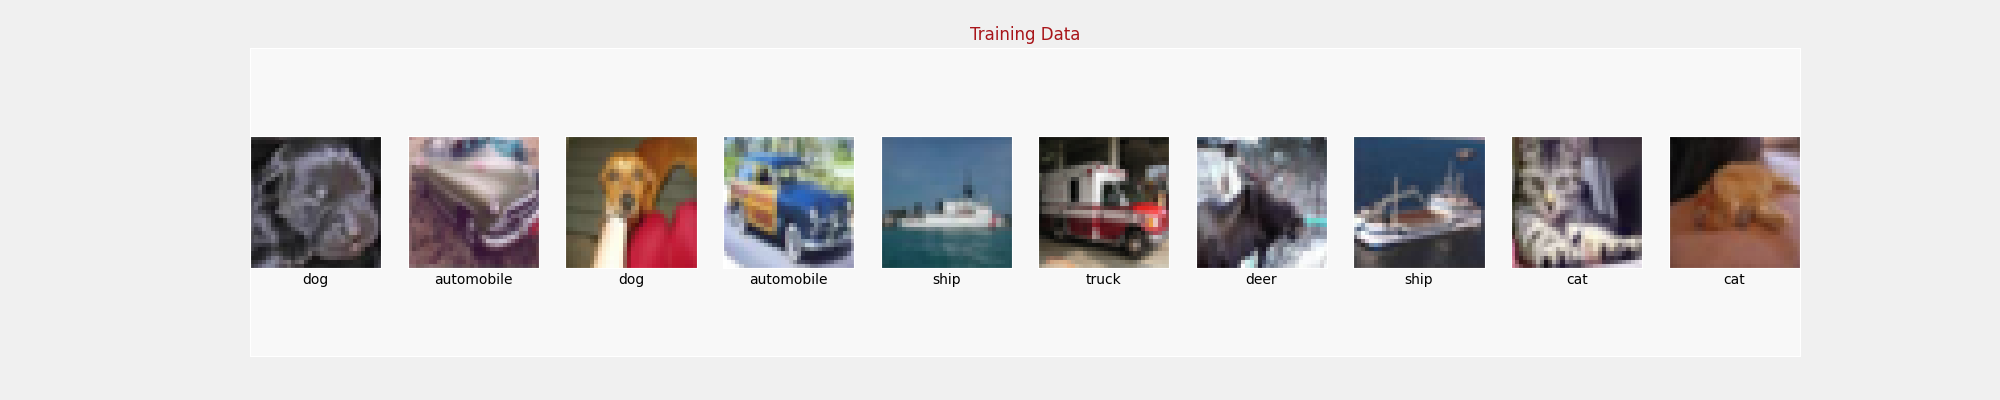

In [6]:
display_images(training_images, training_labels, training_labels, "Training Data" )

<IPython.core.display.Javascript object>


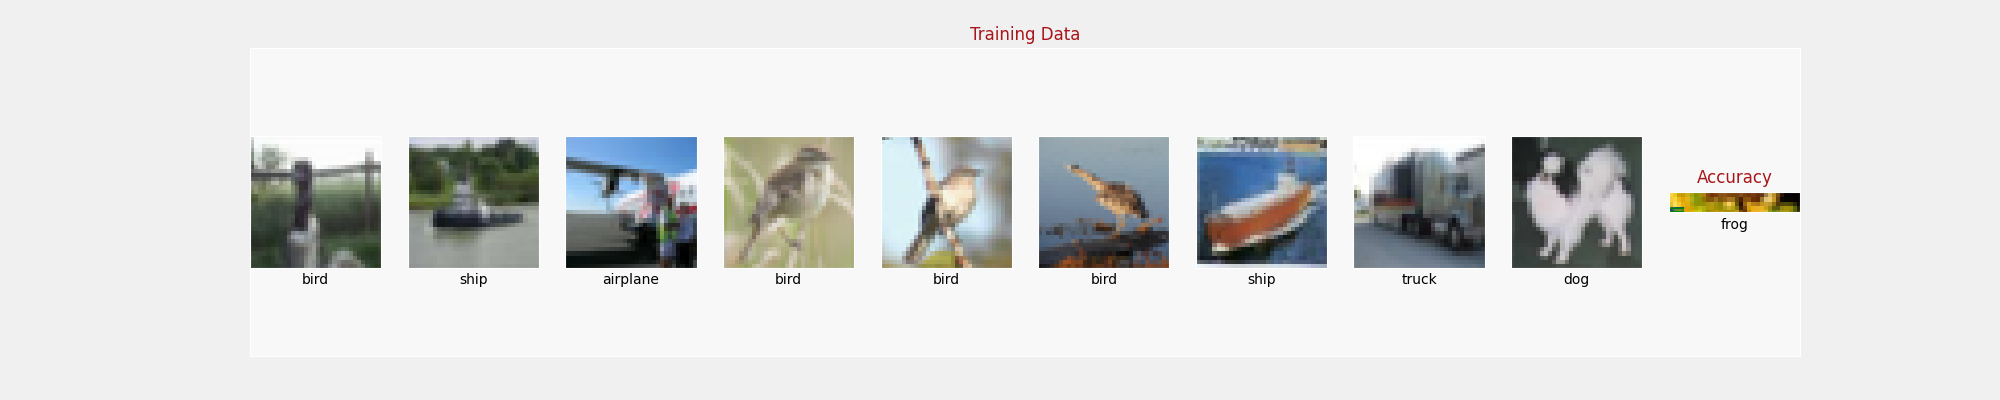

In [7]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [8]:
validation_images[0].astype('float32').shape

(32, 32, 3)

In [9]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [10]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [11]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

94765736/94765736 [==============================] - 13s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                             

In [12]:
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=16)

Epoch 1/4
3125/3125 [==============================] - 539s 168ms/step - loss: 0.3596 - accuracy: 0.8799 - val_loss: 0.1826 - val_accuracy: 0.9372
Epoch 2/4
3125/3125 [==============================] - 431s 138ms/step - loss: 0.1238 - accuracy: 0.9584 - val_loss: 0.1668 - val_accuracy: 0.9451
Epoch 3/4
3125/3125 [==============================] - 422s 135ms/step - loss: 0.0624 - accuracy: 0.9784 - val_loss: 0.1639 - val_accuracy: 0.9490
Epoch 4/4
3125/3125 [==============================] - 423s 135ms/step - loss: 0.0391 - accuracy: 0.9868 - val_loss: 0.1984 - val_accuracy: 0.9472


In [13]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 18s 108ms/step - loss: 0.1984 - accuracy: 0.9472


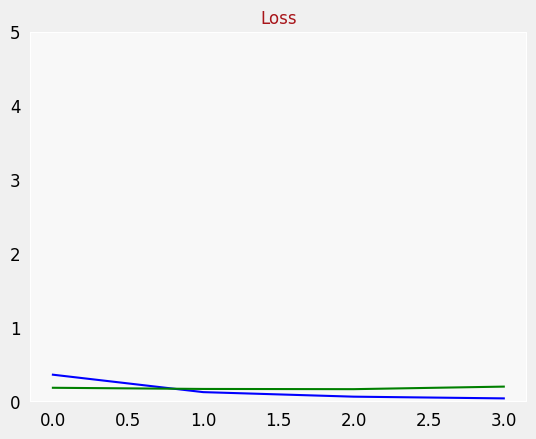

In [17]:
plot_metrics("loss", "Loss")

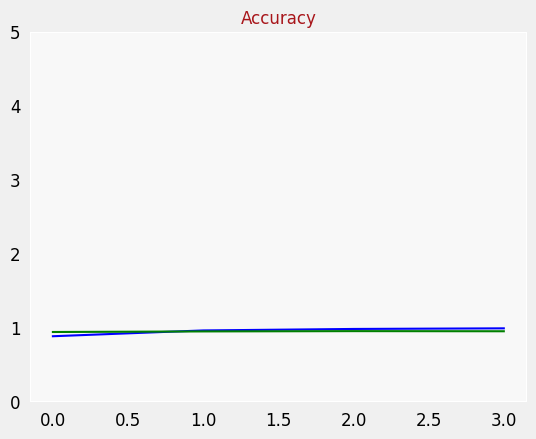

In [18]:
plot_metrics("accuracy", "Accuracy")

157/157 [==============================] - 17s 106ms/step


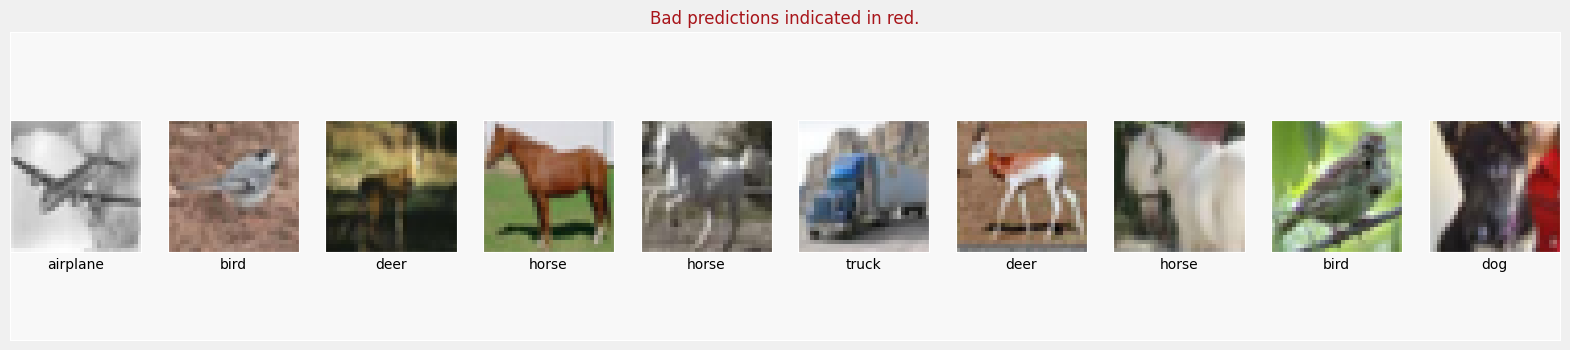

In [19]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")

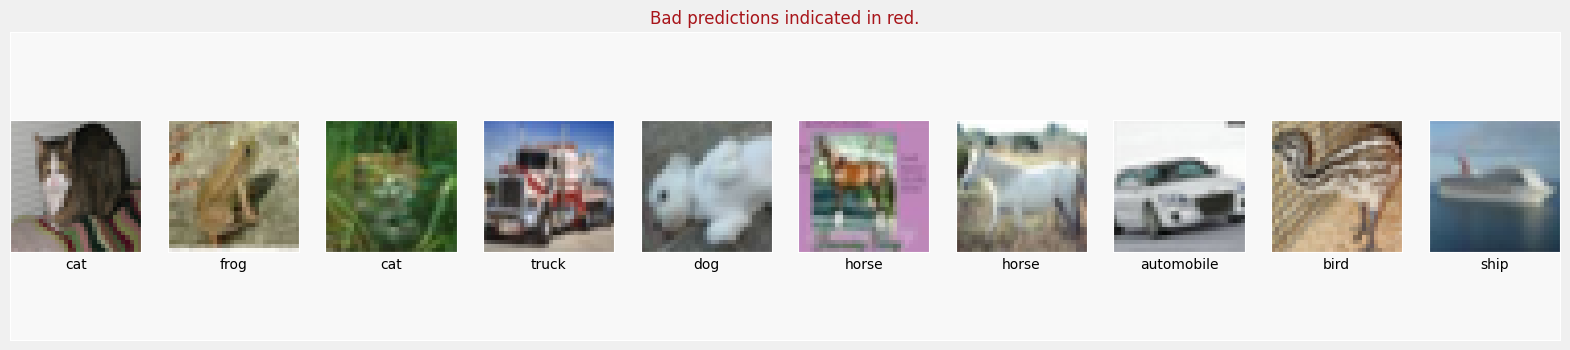

In [22]:
display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")